<a href="https://colab.research.google.com/github/alyosha-swamy/videoCLIP/blob/main/VIDSatCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/microsoft/satclip.git

Cloning into 'satclip'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 250 (delta 61), reused 85 (delta 19), pack-reused 95
Receiving objects: 100% (250/250), 30.46 MiB | 22.55 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [3]:
!pip install lightning --quiet
!pip install rasterio --quiet
!pip install torchgeo --quiet
!pip install basemap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.1/381.1 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.9 MB/s eta 0:0

In [5]:
import sys
sys.path.append('./satclip/satclip')

from load import get_satclip
from huggingface_hub import hf_hub_download
import torch
from sklearn.metrics.pairwise import cosine_similarity
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from math import radians, sin, cos, acos
import pandas as pd


device = "cuda" if torch.cuda.is_available() else "cpu"

model = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ResNet50-L40", "satclip-resnet50-l40.ckpt"),
    return_all=True,
    device=device,
)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


satclip-resnet50-l40.ckpt:   0%|          | 0.00/130M [00:00<?, ?B/s]

using pretrained moco resnet50


Downloading: "https://hf.co/torchgeo/resnet50_sentinel2_all_moco/resolve/da4f3c9dbe09272eb902f3b37f46635fa4726879/resnet50_sentinel2_all_moco-df8b932e.pth" to /root/.cache/torch/hub/checkpoints/resnet50_sentinel2_all_moco-df8b932e.pth
100%|██████████| 90.1M/90.1M [00:01<00:00, 71.5MB/s]


SatCLIP(
  (visual): ResNet(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mome

In [24]:
import subprocess
import os
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity
import rasterio
import matplotlib.pyplot as plt
import warnings
from rasterio.errors import NotGeoreferencedWarning

# Assume these are defined elsewhere in your code
# model, device, control_embs, control_lons, control_lats

# Suppress the specific warning
warnings.filterwarnings('ignore', category=NotGeoreferencedWarning)

def extract_frames(video_path, output_folder, frame_interval=1):
    os.makedirs(output_folder, exist_ok=True)
    ffmpeg_command = [
        'ffmpeg',
        '-i', video_path,
        '-vf', f'fps=1/{frame_interval}',  # Extract 1 frame every 'frame_interval' seconds
        '-f', 'image2',
        f'{output_folder}/frame_%04d.tif'
    ]
    subprocess.run(ffmpeg_command, check=True)

def process_video_frame(path):
    with rasterio.open(path) as f:
        data = f.read().astype(np.float32)
        # Normalize the data
        image = data / np.max(data)

        # Pad or trim channels to match the expected 13 channels
        if image.shape[0] < 13:
            padding = np.zeros((13 - image.shape[0], *image.shape[1:]), dtype=image.dtype)
            image = np.concatenate([image, padding], axis=0)
        elif image.shape[0] > 13:
            image = image[:13]

        return torch.tensor(image)

def estimate_location_from_video(video_path, output_folder, frame_interval=1):
    # Extract frames from video
    extract_frames(video_path, output_folder, frame_interval)

    frame_paths = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.tif')]

    estimated_locations = []
    for frame_path in frame_paths:
        image = process_video_frame(frame_path)

        # Compute image embedding
        with torch.no_grad():
            img_emb = model.visual(image.unsqueeze(0).to(device))

        # Find closest control embedding
        cosine_sim = cosine_similarity(img_emb.cpu().numpy(), control_embs.cpu().numpy())
        closest = np.argmax(cosine_sim)

        # Get corresponding location
        estimated_location = control_lons[closest], control_lats[closest]
        estimated_locations.append(estimated_location)

    # Calculate average location
    avg_location = np.mean(estimated_locations, axis=0)

    return avg_location

# Example usage
video_path = '/content/videos/nevada.mp4'
output_folder = '/content/videos/frames'
estimated_location = estimate_location_from_video(video_path, output_folder)

print(f"Estimated average location (lon, lat): {estimated_location}")
print("Note: True location should be the coordinates of North Sierra Nevada, California")

Estimated average location (lon, lat): [168.94410939 -71.14010723]
Note: True location should be the coordinates of North Sierra Nevada, California


In [6]:
def get_example_image(path, plot=True):
    """
    Loads example Sentinel-2 image from path to tif file
    :param path: Path to image file
    :param plot: If True, will plot an RGB image of the satellite image
    :return: Normalized image as torch tensor
    """
    with rasterio.open(path) as f:
            data = f.read().astype(np.float32)
            image = data / 10000.0
            B10 = np.zeros((1, *image.shape[1:]), dtype=image.dtype)
            image = np.concatenate([image[:10], B10, image[10:]], axis=0)
            image = torch.tensor(image)

            if plot:
                    # Read the first three RGB bands (assuming they are bands 4, 3, and 2)
                    red_band = f.read(4) / 10000.0
                    green_band = f.read(3) / 10000.0
                    blue_band = f.read(2) / 10000.0

                    # Stack the bands to create an RGB image
                    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

                    # Plot the RGB image
                    plt.imshow(rgb_image)
                    plt.title("RGB Sentinel-2 Image")
                    plt.axis('off')  # Hide axes
                    plt.show()

    return image

def generate_control_locations(n):
    """
    Generates n regularly distributed locations on the planet
    :param n: Number of locations to generate
    :return: longitudes, latitudes of generated locations
    """
    import math
    n = n // 2
    # golden ratio
    phi = (1 + math.sqrt(5)) / 2

    lats, lons = [], []

    for i in np.arange(-n, n):
        lat = np.arcsin( (2*i) / (2*n + 1) ) * 180 / np.pi
        lon = (i % phi) * (360 / phi)

        if lon < -180:
            lon += 360
        if lon > 180:
            lon -= 360

        lons.append(lon)
        lats.append(lat)

    return np.stack(lons), np.stack(lats)

def arc_distance(lon1, lat1, lon2, lat2):
    """
    Calculates the great-circle distance between two points on Earth.
    :param lat1: Latitude of location 1 (in degrees)
    :param lon1: Longitude of location 1 (in degrees)
    :param lat2: Latitude of location 2 (in degrees)
    :param lon2: Longitude of location 2 (in degrees)
    :return: Distance in kilometers
    """
    mlat = radians(lat1)
    mlon = radians(lon1)
    plat = radians(lat2)
    plon = radians(lon2)

    dist = 6371.01 * acos(sin(mlat) * sin(plat) + cos(mlat) * cos(plat) * cos(mlon - plon))
    return dist


In [7]:
#Generate control locations
control_lons, control_lats = generate_control_locations(100000)
locs = torch.tensor(np.stack([control_lons, control_lats], axis=1)).to(device)
#Get location embeddings of control locations
with torch.no_grad():
  control_embs = model.encode_location(locs)

In [8]:
locations = pd.read_csv('https://satclip.z13.web.core.windows.net/satclip/index.csv')

In [18]:
import subprocess
import os

def extract_frames(video_path, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Construct the ffmpeg command
    ffmpeg_command = [
        'ffmpeg',
        '-i', video_path,
        '-vf', 'fps=1',  # Extract 1 frame per second, adjust as needed
        '-f', 'image2',  # Force image2 format
        '-pix_fmt', 'rgb24',  # Set pixel format to RGB
        f'{output_folder}/frame_%04d.tiff'
    ]

    # Run the ffmpeg command
    subprocess.run(ffmpeg_command, check=True)

# Example usage
video_path = '/content/videos/nevada.mp4'
output_folder = '/content/videos/'

extract_frames(video_path, output_folder)
print("TIFF frames extracted successfully!")

TIFF frames extracted successfully!


In [9]:
  #Path to example images
  paths = ['https://github.com/microsoft/satclip/raw/main/figures/example_s2/patch_445.tif',
          'https://github.com/microsoft/satclip/raw/main/figures/example_s2/patch_8845.tif',
          'https://github.com/microsoft/satclip/raw/main/figures/example_s2/patch_33188.tif'
          ]
  #Chose one!
  path = paths[1]

In [21]:
import subprocess
import os
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms

# Assume these are defined elsewhere in your code
# model, device, control_embs, locations

def extract_frames(video_path, output_folder, frame_interval=1):
    os.makedirs(output_folder, exist_ok=True)
    ffmpeg_command = [
        'ffmpeg',
        '-i', video_path,
        '-vf', f'fps=1/{frame_interval}',  # Extract 1 frame every 'frame_interval' seconds
        '-f', 'image2',
        '-pix_fmt', 'rgb24',
        f'{output_folder}/frame_%04d.tiff'
    ]
    subprocess.run(ffmpeg_command, check=True)

def get_image(path):
    if path.startswith('http'):
        response = requests.get(path)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(path)
    return img.convert('RGB')

def preprocess_image(image, target_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0)

def estimate_location_from_video(video_path, output_folder, frame_interval=1):
    # Extract frames from video
    extract_frames(video_path, output_folder, frame_interval)

    frame_paths = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.tiff')]

    locations = []
    for frame_path in frame_paths:
        image = get_image(frame_path)
        image_tensor = preprocess_image(image).to(device)

        # Compute image embedding
        with torch.no_grad():
            img_emb = model.visual(image_tensor)

        # Find closest control embedding
        cosine_sim = cosine_similarity(img_emb.cpu().numpy(), control_embs.cpu().numpy())
        closest = np.argmax(cosine_sim)

        # Get corresponding location
        location = locations.iloc[closest][['lon', 'lat']].values
        locations.append(location)

    # Calculate average location
    avg_location = np.mean(locations, axis=0)

    return avg_location

# Example usage
video_path = '/content/videos/nevada.mp4'
output_folder = '/content/videos/'
estimated_location = estimate_location_from_video(video_path, output_folder)

print(f"Estimated location (lon, lat): {estimated_location}")
print("Note: True location should be the coordinates of North Sierra Nevada, California")

RuntimeError: Given groups=1, weight of size [64, 13, 7, 7], expected input[1, 3, 224, 224] to have 13 channels, but got 3 channels instead

In [11]:
#Get location corresponding to image from the index dataframe
loc = locations[locations['fn'] == path.split('/')[-1]][['lon','lat']].values

In [12]:
#Compute image embedding
img_emb = model.visual(image.unsqueeze(0).to(device))

In [13]:
#Find row in control_embs that is closest to loc_emb by cosine similarity
cosine_sim = cosine_similarity(img_emb.cpu().detach().numpy(), control_embs.cpu().detach().numpy())
#Get index of control location corresponding to embedding with highest cosine similarity to image embedding
closest = np.argmax(cosine_sim)

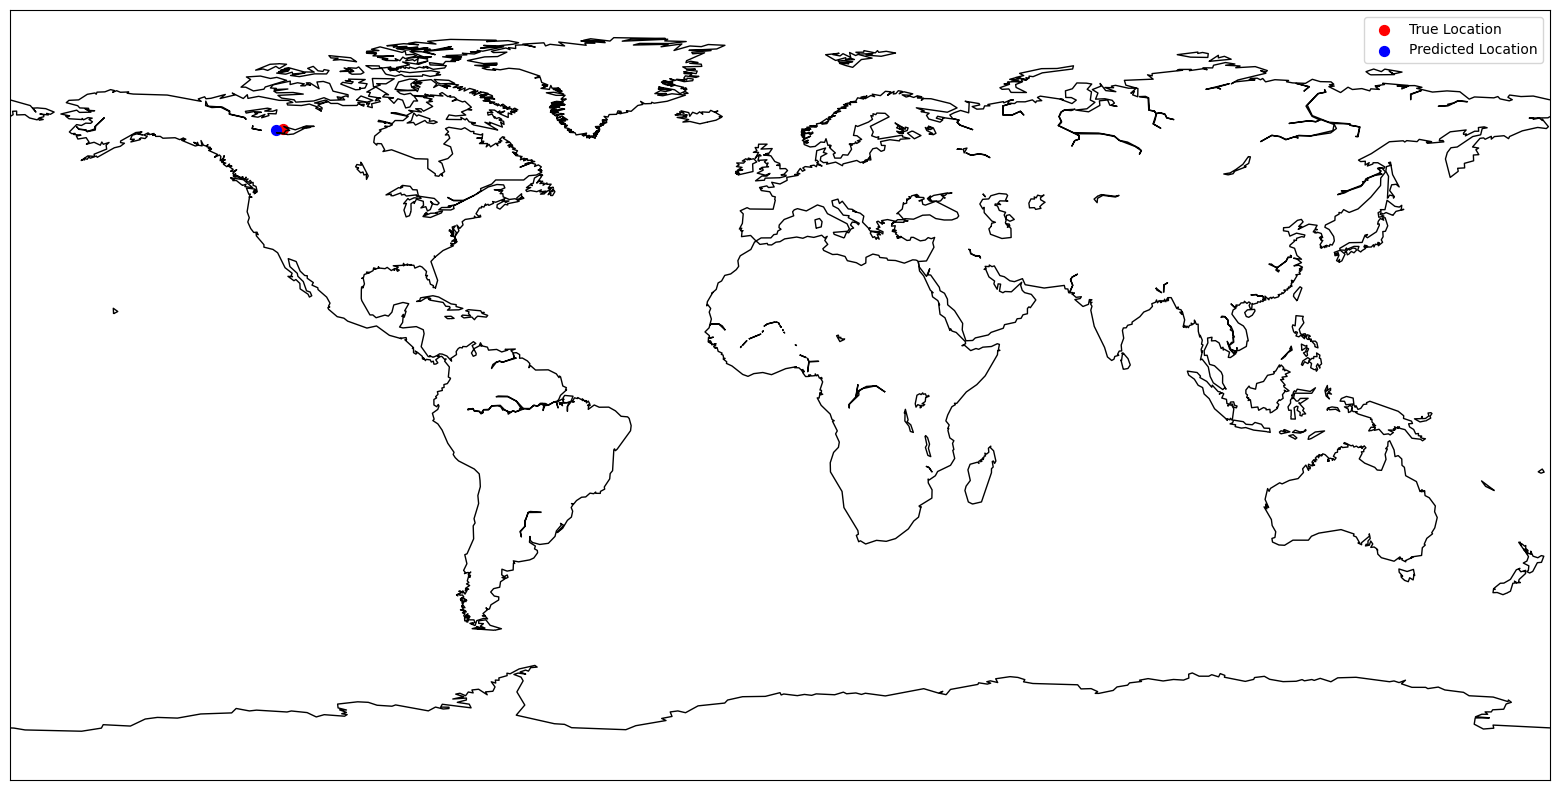

In [14]:
#Plot true and predicted locations
fig, ax = plt.subplots(1,1, figsize=(20, 10))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
ax.scatter(loc[0][0], loc[0][1], s=50, c="red", label="True Location")
ax.scatter(control_lons[closest], control_lats[closest], s=50, c="blue", label="Predicted Location")
ax.legend()ate

In [15]:
distance = arc_distance(loc[0][0], loc[0][1], control_lons[closest], control_lats[closest])
print(f"The distance between the two locations is approximately {distance:.2f} km.")

The distance between the two locations is approximately 81.70 km.
